# Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error

# Load and inflate prices

In [2]:
df = pd.read_csv("data/coords/coords_HDB.csv")

#use of cpi to deflate/inflate prices as next best tool since unable to locate ooa stats online
cpi = pd.read_csv("data/cpi.csv")
cpi.head()

,year,level_1,value
0,1990,MAS Core Inflation Measure,62.094
1,1991,MAS Core Inflation Measure,64.359
2,1992,MAS Core Inflation Measure,65.398
3,1993,MAS Core Inflation Measure,66.562
4,1994,MAS Core Inflation Measure,68.246


In [3]:
#base yr in 2019
print(cpi[cpi.value==100])

#2014 base value
cpi.value[cpi.year==2014]

    year                     level_1  value
29  2019  MAS Core Inflation Measure  100.0


24    94.607
Name: value, dtype: float64

In [4]:
#rebase it to 2014 to try predict prices in 2015
cpi['new_value'] = cpi['value']/94.607*100
cpi.iloc[24]['new_value']

100.0

In [5]:
#merge df
merged = pd.merge(df, cpi, how='left', left_on='year_sold', right_on='year')

#inflate/deflate all prices
merged['new_resale_price'] = merged['resale_price'] / merged['new_value'] *100
merged.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year_sold,mth_sold,age_sold,lat,long,year,level_1,value,new_value,new_resale_price
0,ANG MO KIO,4 ROOM,211,ANG MO KIO AVE 3,04 TO 06,81.0,NEW GENERATION,80000.0,1990,1,13.0,1.369197,103.841667,1990.0,MAS Core Inflation Measure,62.094,65.633621,121888.749316
1,ANG MO KIO,4 ROOM,209,ANG MO KIO AVE 3,07 TO 09,91.0,NEW GENERATION,72000.0,1990,1,13.0,1.368971,103.843285,1990.0,MAS Core Inflation Measure,62.094,65.633621,109699.874384
2,ANG MO KIO,4 ROOM,231,ANG MO KIO AVE 3,04 TO 06,92.0,NEW GENERATION,72000.0,1990,1,13.0,1.368561,103.837525,1990.0,MAS Core Inflation Measure,62.094,65.633621,109699.874384
3,ANG MO KIO,4 ROOM,308,ANG MO KIO AVE 1,10 TO 12,92.0,NEW GENERATION,86000.0,1990,1,14.0,1.365697,103.844347,1990.0,MAS Core Inflation Measure,62.094,65.633621,131030.405514
4,ANG MO KIO,4 ROOM,254,ANG MO KIO AVE 4,10 TO 12,97.0,NEW GENERATION,72000.0,1990,1,13.0,1.370203,103.834688,1990.0,MAS Core Inflation Measure,62.094,65.633621,109699.874384


In [6]:
yishun = merged.where((merged.town=="YISHUN") )
yishun.dropna(inplace=True)

yishun = yishun.filter(["storey_range", "floor_area_sqm", "flat_type", "flat_model", "year_sold", "age_sold", "new_resale_price"])
yishun.shape

(64774, 7)

In [7]:
#extract only data before 2017 to prevent data leakage
#2013 chosen as cutoff for its proximity of year and number of samples for training
#2013-6 and prior for training/CV; 2017 data for testing
yishun = yishun.where((yishun.year_sold>=2013) & (yishun.year_sold<2018))
yishun.dropna(inplace=True)

train = yishun.where((yishun.year_sold>=2013) & (yishun.year_sold<2017))
train.dropna(inplace=True)

test = yishun.where(yishun.year_sold==2017)
test.dropna(inplace=True)

print(train.shape)
print(test.shape) #about 21.7% of train data 

(4387, 7)
(1249, 7)


In [8]:
yishun.corr()

,floor_area_sqm,year_sold,age_sold,new_resale_price
floor_area_sqm,1.000000,0.031118,-0.097001,0.869371
year_sold,0.031118,1.000000,-0.000883,-0.244847
age_sold,-0.097001,-0.000883,1.000000,-0.193563
new_resale_price,0.869371,-0.244847,-0.193563,1.000000


# Visualisation

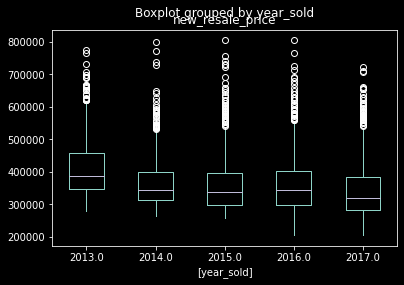

In [9]:
yishun.boxplot(by =["year_sold"], column =['new_resale_price'], grid = False);

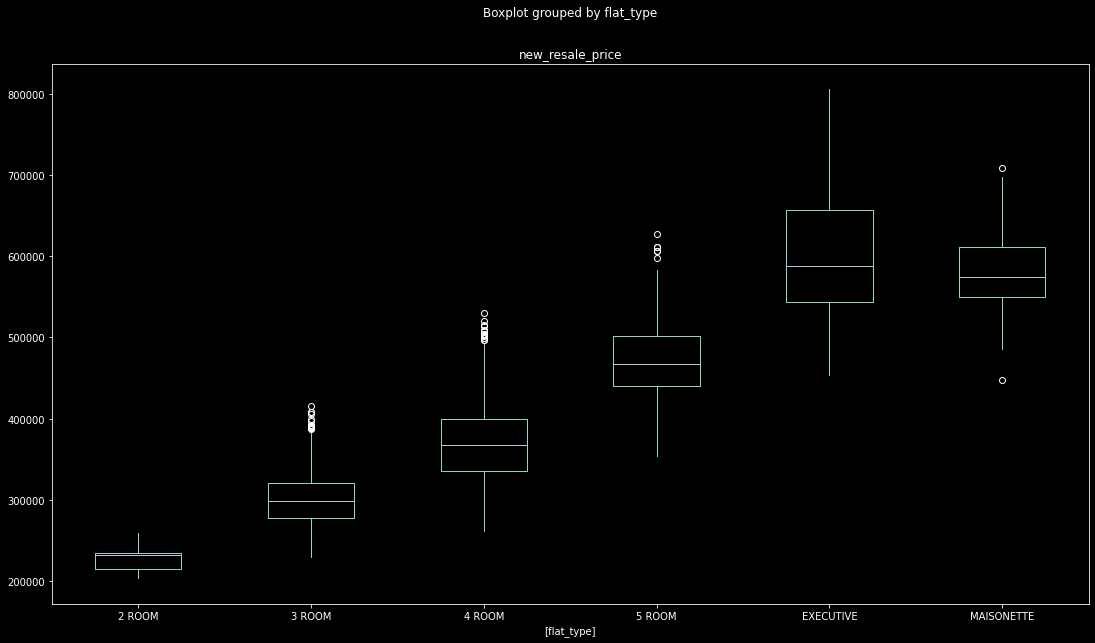

In [10]:
yishun.boxplot(by =["flat_type"], column =['new_resale_price'], figsize = (18,10), grid = False);

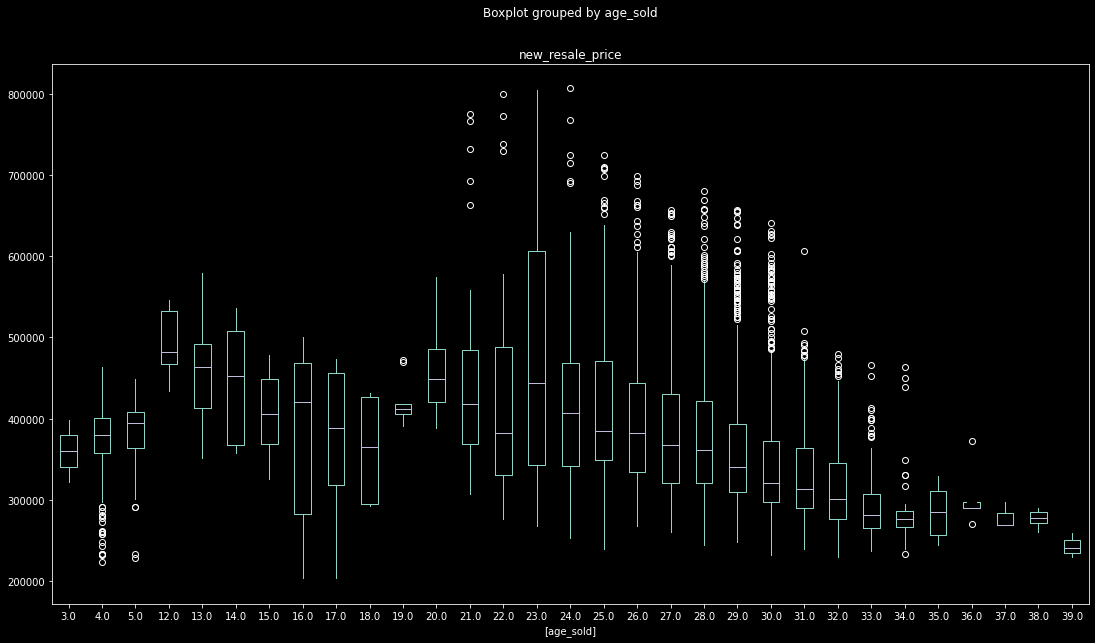

In [11]:
yishun.boxplot(by =["age_sold"], column =['new_resale_price'], figsize = (18,10), grid = False);

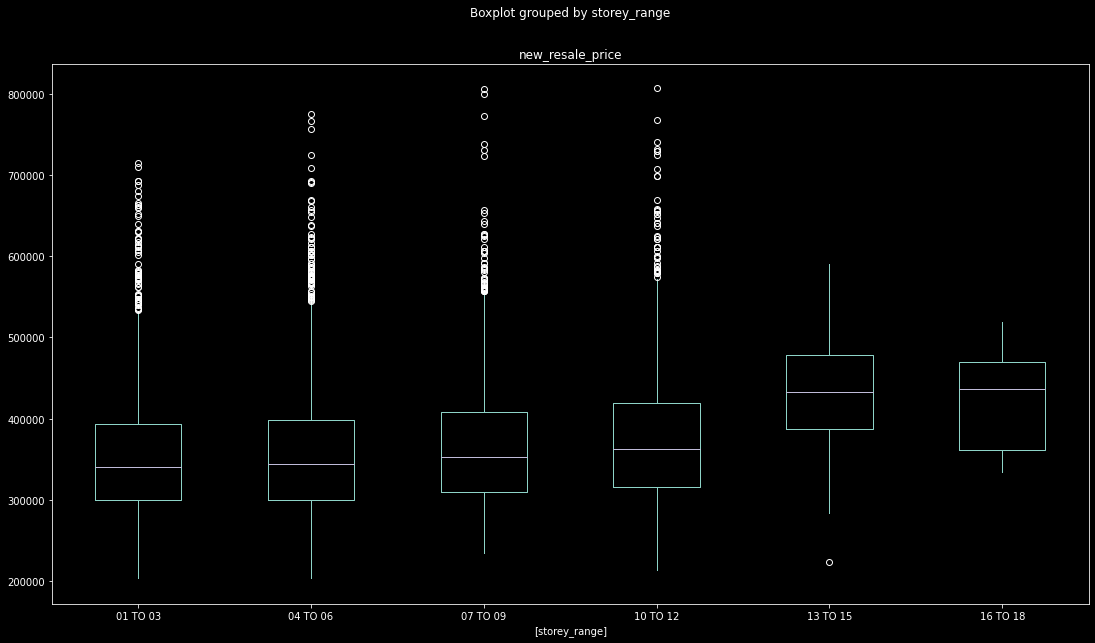

In [12]:
yishun.boxplot(by =["storey_range"], column =['new_resale_price'], figsize = (18,10), grid = False);

# Data Preparation

In [13]:
#Add dummy variables to categorical data
yishun = pd.get_dummies(data=yishun, drop_first=True)

In [14]:
#set model weights based on year sold and subsequently use that column as weight
yishun['year_sold'] = np.where(yishun['year_sold'] == 2013, 20, yishun['year_sold'])
yishun['year_sold'] = np.where(yishun['year_sold'] == 2014, 20, yishun['year_sold'])
yishun['year_sold'] = np.where(yishun['year_sold'] == 2015, 30, yishun['year_sold'])
yishun['year_sold'] = np.where(yishun['year_sold'] == 2016, 40, yishun['year_sold'])

In [15]:
#Split train test set
train = yishun.where((yishun.year_sold>=20) & (yishun.year_sold<50))
train.dropna(inplace=True)

test = yishun.where(merged.year_sold==2017)
test.dropna(inplace=True)

X_train = train.drop(['year_sold', 'new_resale_price'], axis=1)
X_train_weights = pd.DataFrame(train["year_sold"]).to_numpy()
X_test = test.drop(['year_sold', 'new_resale_price'], axis=1)

y_train = train['new_resale_price']
y_test  = test['new_resale_price']

# Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

def run_LM(weighted):
    #fit model
    model = LinearRegression()
    if weighted:
        model.fit(X_train,y_train, X_train_weights.ravel())
    else:
        model.fit(X_train,y_train)
    predictions = model.predict(X_test)

    #assess model
    RMSE = mean_squared_error(y_test, predictions, squared=False)
    R2 = r2_score(y_test, predictions)
    return RMSE, R2, model

In [17]:
RMSE, R2, model = run_LM(False)
print("Unweighted LM model RMSE = ", RMSE, "; R2 = ", R2)
RMSE, R2, model = run_LM(True)
print("Weighted LM model RMSE = ", RMSE, "; R2 = ", R2)

Unweighted LM model RMSE =  42878.55835248335 ; R2 =  0.7257922142908784
Weighted LM model RMSE =  39093.61511052492 ; R2 =  0.7720649581657775


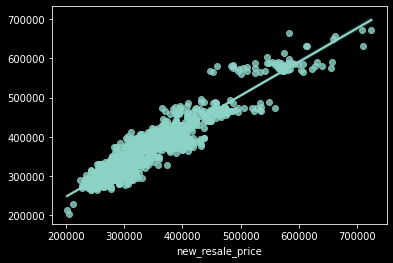

In [18]:
predictions = model.predict(X_test)
sns.regplot(x=y_test,y=predictions);

# Random Forest

In [19]:
#try using RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
print("\nTrain RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print("Train R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_train, y_pred_train),0))

y_pred_test = rf.predict(X_test)
print("\nTest RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print("Test R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_test, y_pred_test),0))


Train RMSE using sklearn RandomForestRegressor model: 26211.3
Train R2 using sklearn RandomForestRegressor model: 1.0

Test RMSE using sklearn RandomForestRegressor model: 36108.63
Test R2 using sklearn RandomForestRegressor model: 1.0


# XGBoost

In [20]:
#using most popular model to try
from xgboost import XGBRegressor
xgb = XGBRegressor(eval_metric = "rmse").fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
print("\nTrain RMSE using sklearn XGBoost model:",
round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print("Train R2 using sklearn XGBoost model:",
round(r2_score(y_train, y_pred_train),0))

y_pred_test = xgb.predict(X_test)
print("\nTest RMSE using sklearn XGBoost model:",
round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print("Test R2 using sklearn XGBoost model:",
round(r2_score(y_test, y_pred_test),0))


Train RMSE using sklearn XGBoost model: 26544.524
Train R2 using sklearn XGBoost model: 1.0

Test RMSE using sklearn XGBoost model: 36960.103
Test R2 using sklearn XGBoost model: 1.0


# Check price

In [21]:
flat = X_train.iloc[[0]]
flat.iloc[0] = [91,2017-1984,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0]

C:\Users\enchi\AppData\Local\Temp\ipykernel_16568\1932474841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat.iloc[0] = [91,2017-1984,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0]


In [22]:
xgb.predict(flat.iloc[[0]])

array([354793.38], dtype=float32)

In [23]:
check_flat = merged.where((merged.town=="YISHUN") &
#                       (merged.storey_range=="10 TO 12") &
                      (merged.flat_type=="4 ROOM") &
#                       (merged.flat_model=="NEW GENERATION") &
                      (merged.floor_area_sqm>=90) &
                      (merged.age_sold>30) &
                      (merged.year_sold==2017)
                     )
check_flat.dropna(inplace=True)
check_flat.resale_price.describe()

count       117.000000
mean     368917.025641
std       33152.314396
min      308000.000000
25%      343000.000000
50%      365000.000000
75%      393000.000000
max      445000.000000
Name: resale_price, dtype: float64